##### 샘플 데이터

In [1]:
import pandas as pd
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open("헬스 클러스터링 결과.pkl", "rb") as file :
    df = pickle.load(file)
df.head()

,time,Review,tagged_review,vector,cluster
0,2023. 5. 3. 11:52,좋은시와 글 홈트를 해요 영원한 물론입니다 여러분과 함께 홈트를 즐길 수 있는 영상...,"[좋다, 은시, 글, 홈트, 해, 영원하다, 홈트, 즐기다, 수, 영상, 준비, 영...","[0.8202861, 1.2661822, 0.11358889, 1.4388651, ...",0
1,2023. 5. 3. 10:02,뭘써볼까 는 집에서 틈틈이 운동하기 위해 홈트용 운동기구를 애요해요 꾸준히 하는 나...,"[뭘, 써다, 보다, 늘다, 집, 틈틈이, 운동, 위해, 홈트용, 운동, 기구, 애...","[0.51687, -0.23826225, -0.48169875, 0.9579804,...",4
2,2023. 5. 3. 9:01,주절주절 홈트를 해요 대 필수 매일 조금씩 세 줌마입니다 대 필수라고 생각하는 근...,"[홈트, 해, 대다, 필수, 매일, 세, 줌마, 대다, 필수, 생각, 근력, 운동,...","[0.6595078, 0.017418364, 1.2061758, 0.65224504...",1
3,2023. 2. 23. 19:00,건강 관리는 꾸준한 운동이 정답인것 같아요 건강 관리는 꾸준한 운동이 정답인것 같...,"[건강, 관리, 꾸준하다, 운동, 정답, 건강, 관리, 꾸준하다, 운동, 정답, 먹...","[-0.286165, -0.0006382484, -0.51053077, -0.286...",4
4,2021. 11. 10. 10:00,안녕 운동 운동 운동은매일매일출퇴근을 자전거로 해요분정도전력질주는 아니구요그리고 ...,"[안녕, 운동, 운동, 운동, 매일, 출퇴근, 자전거, 해, 분, 정도전, 질주, ...","[0.25458983, 0.1775183, -0.037466936, 0.238791...",4


# ◆ 1. LDA를 위한 데이터 전처리
* 1.1. 전체 단어의 사전 만들고 각 문서에 매칭하기
    > 단어들이 문서에 얼마나 위치해 있는지 분포를 파악해야하기 때문에 분석할 전체 데이터 대상으로
    사용된 단어의 사전을 생성해야한다,


In [3]:
# LDA 모델 그리기 위해 필요한 것들
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary

### 1.1 전체 단어의 사전 만들고 각 문서에 매칭하기

In [41]:
df_cluster1 = df[df['cluster'] == 1]
df_cluster1

,time,Review,tagged_review,vector,cluster
2,2023. 5. 3. 9:01,주절주절 홈트를 해요 대 필수 매일 조금씩 세 줌마입니다 대 필수라고 생각하는 근...,"[홈트, 해, 대다, 필수, 매일, 세, 줌마, 대다, 필수, 생각, 근력, 운동,...","[0.6595078, 0.017418364, 1.2061758, 0.65224504...",1
10,2021. 11. 10. 14:37,운동 운동 영상 주 회는 운동 하는 중다른 사람들 방해될까봐 그리고 부끄러워서 운...,"[운동, 운동, 영상, 주, 회, 운동, 중, 사람, 방해, 부끄럽다, 운동, 영상...","[0.63065374, -0.3632866, -0.5204896, -0.094380...",1
17,2021. 11. 10. 20:11,찐 데일리 겨울에도 즐길 수 있는 실내 스포츠 테린이의 운동 운동그동안 깔짝거리며...,"[찌다, 데, 일리, 겨울, 즐기다, 수, 실내, 스포츠, 테린, 이의, 운동, 운...","[-0.70090955, -1.495075, 0.511196, -0.02174461...",1
35,2023. 2. 24. 10:37,리추얼 라이프 나의 건강 관리법 의 질문나만의 규칙적인 습관리추얼 라이프대개 거창...,"[리추얼, 라이프, 건강, 관리, 법, 질문, 규칙, 습, 관리, 추얼, 라이프, ...","[1.0538049, -0.795101, 0.18260065, -0.71494114...",1
52,2021. 11. 10. 15:51,운동 코로나를 이기지못하고 사라진룩스필라테스 군자점 오랜만에 포스팅을 올립니다한번 ...,"[운동, 코로나, 이기, 못, 사라지다, 룩스, 필라테스, 군자, 점, 만, 포스팅...","[-1.5950105, 1.7140973, -0.025785215, 3.719138...",1
...,...,...,...,...,...
708,2021. 11. 10. 14:24,화동사범대 석사 중 당기기 운동 제 운동 영상이요중에서 당기기 운동을 할 기회를...,"[화동, 사범대, 석사, 중, 기기, 운동, 운동, 영상, 이요, 기기, 운동, 기...","[-0.1322695, -0.20870452, 0.207569, 1.3700012,...",1
732,2022. 11. 5. 8:00,공지 잠실 댄스학원 중급반 이지댄스 잠실점입니다 의 는 운동 주제군요 저는 요새 춤...,"[공지, 잠실, 댄스, 학원, 중, 반, 댄스, 잠실, 점, 늘다, 운동, 주제, ...","[-0.73634195, 0.7777958, -0.43400747, 1.619193...",1
736,2022. 11. 1. 9:21,나는야 취미부자 운동 일지 위치더클라임 클라이밍 짐앤샵 연남점 제 를 보시는 분들이...,"[취미, 부자, 운동, 일지, 위치, 더, 크다, 라임, 크다, 밍, 짐앤, 연남,...","[1.3654749, -0.4165057, -0.14446345, 0.3720104...",1
743,2023. 5. 3. 17:00,데일리 홈트 시작 이렇게 하니 좋았어요 개월 내돈내산 홈트를 시작한지도 벌써 개월...,"[데, 일리, 홈트, 시작, 하니, 좋다, 개월, 돈, 산, 홈트, 지도, 벌써, ...","[2.9176116, 2.6359224, -2.123454, 1.3806118, -...",1


In [42]:
all_documents = list(df_cluster1['tagged_review'])

dictionary = Dictionary(all_documents)
dictionary

In [43]:
dictionary.token2id

{'가다': 0,
 '가량': 1,
 '가지': 2,
 '개': 3,
 '개도': 4,
 '거': 5,
 '거기': 6,
 '거나': 7,
 '걸': 8,
 '게': 9,
 '겠다': 10,
 '결과': 11,
 '굽': 12,
 '굽히다': 13,
 '근력': 14,
 '근육': 15,
 '기구': 16,
 '깨달': 17,
 '꾸준하다': 18,
 '나이': 19,
 '날': 20,
 '내': 21,
 '노력': 22,
 '다행': 23,
 '단단하다': 24,
 '대다': 25,
 '도': 26,
 '도움': 27,
 '되어다': 28,
 '드리다': 29,
 '들다': 30,
 '들어가다': 31,
 '듯해': 32,
 '롤러': 33,
 '매일': 34,
 '모르다': 35,
 '무료': 36,
 '백배': 37,
 '밸런스': 38,
 '번': 39,
 '번은': 40,
 '보내다': 41,
 '보다': 42,
 '보드': 43,
 '비': 44,
 '빠지다': 45,
 '사실': 46,
 '사용': 47,
 '산소': 48,
 '살': 49,
 '살이': 50,
 '생각': 51,
 '생각나다': 52,
 '세': 53,
 '세트': 54,
 '소소하다': 55,
 '수': 56,
 '스트레칭': 57,
 '시작': 58,
 '아파트': 59,
 '안': 60,
 '안쪽': 61,
 '없다': 62,
 '오다': 63,
 '올라가다': 64,
 '옷': 65,
 '요가': 66,
 '요런': 67,
 '운동': 68,
 '유': 69,
 '유지': 70,
 '이용': 71,
 '이제': 72,
 '자다': 73,
 '잠자다': 74,
 '전': 75,
 '정도': 76,
 '정말': 77,
 '젖다': 78,
 '좋다': 79,
 '줌마': 80,
 '중요하다': 81,
 '진짜': 82,
 '집': 83,
 '충분하다': 84,
 '치다': 85,
 '친정엄마': 86,
 '특별하다': 87,
 '틈나다': 88,
 '팔뚝': 89,
 '펴다':

In [45]:
corpus = []
for doc in all_documents :
    corpus.append(dictionary.doc2bow(doc))
corpus # (id값, 빈도수)
len(corpus) # doc 값과 동일

71

# ◆ 2. LDA모델 만들기
* 2.1 LDA 기본 모델 만들기
* 2.2 LDA 토픽개수 선정
* 2.3 선정한 토픽 개수로 Action 넘버 매칭

### 2.1 LDA 기본 모델 만들기

In [46]:
topic_num = 3 # 임의로 가정

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = topic_num, id2word =dictionary ) # 코드 불러오는 모델


In [47]:
lda_model.print_topics(num_words = 10) # 3개의 토픽에 대하여 5개의 주제 단어 정렬, 정렬순서는 큰 숫자 부터

[(0,
  '0.032*"운동" + 0.010*"보다" + 0.006*"않다" + 0.006*"영상" + 0.006*"좋다" + 0.006*"수" + 0.005*"분" + 0.005*"동작" + 0.005*"홈트" + 0.005*"들다"'),
 (1,
  '0.032*"운동" + 0.009*"보다" + 0.007*"점" + 0.006*"홈트" + 0.006*"들다" + 0.005*"자세" + 0.005*"영상" + 0.005*"수" + 0.005*"필라테스" + 0.005*"없다"'),
 (2,
  '0.042*"운동" + 0.009*"보다" + 0.007*"않다" + 0.007*"좋다" + 0.006*"영상" + 0.006*"수" + 0.004*"없다" + 0.004*"시작" + 0.004*"요가" + 0.004*"자세"')]

In [48]:
# 하나 뽑고 싶을 때
lda_model.get_document_topics(corpus)[0] # 첫 번째 문서에 대한 값 -> 1번 토픽일 것이다 -> 데이터에 새로운 열로 붙이기

[(0, 0.99502194)]

In [49]:
for i in range(len(corpus)) : 
    print(lda_model.get_document_topics(corpus)[i])

[(0, 0.9950259)]
[(0, 0.024754565), (2, 0.97255224)]
[(2, 0.99318546)]
[(2, 0.9953573)]
[(1, 0.997654)]
[(1, 0.9962396)]
[(2, 0.9958156)]
[(0, 0.72101396), (1, 0.27722216)]
[(1, 0.9931308)]
[(0, 0.082731344), (2, 0.91546696)]
[(0, 0.04171314), (1, 0.2698648), (2, 0.6884221)]
[(1, 0.99386984)]
[(2, 0.98910344)]
[(0, 0.021856738), (1, 0.9633202), (2, 0.014823081)]
[(1, 0.99738103)]
[(2, 0.99357307)]
[(0, 0.9982265)]
[(2, 0.99477834)]
[(0, 0.66063756), (1, 0.012732372), (2, 0.32663006)]
[(0, 0.9022758), (1, 0.09710218)]
[(2, 0.9953149)]
[(1, 0.9955411)]
[(2, 0.99219704)]
[(0, 0.9839294), (1, 0.014583763)]
[(2, 0.99542785)]
[(0, 0.9869411), (1, 0.011037337)]
[(1, 0.0852186), (2, 0.9096683)]
[(0, 0.13103099), (1, 0.86717904)]
[(2, 0.99228334)]
[(0, 0.012227887), (1, 0.986514)]
[(2, 0.98900324)]
[(0, 0.9927365)]
[(2, 0.99542)]
[(0, 0.97819775), (2, 0.020315425)]
[(0, 0.99776196)]
[(1, 0.09308317), (2, 0.90489215)]
[(0, 0.9915717)]
[(0, 0.9960581)]
[(0, 0.99848115)]
[(2, 0.9961594)]
[(0, 0.99

### 2.2 LDA 토픽개수 선정
* cohearence & perplexcity

In [50]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np

In [51]:
perplex_score = lda_model.log_perplexity(corpus)
perplex_score

-7.700551278017308

In [52]:
coherence_model = CoherenceModel(model = lda_model, texts = all_documents, dictionary = dictionary, topn = 3)
coherence_model.get_coherence()

0.5964801247053436

> 2.2.1 Perplexity 그래프 만들기

In [53]:
perplexity_values = []
for i in range(2, 10) :
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = i, id2word = dictionary)
    perp_v = lda_model.log_perplexity(corpus)
    perplexity_values.append(perp_v)
perplexity_values

[-7.573569456401934,
 -7.693669113445445,
 -7.794935882726248,
 -7.886902553709618,
 -8.064490778839517,
 -8.113078865284933,
 -8.254777744804304,
 -8.282632405371317]

Text(0, 0.5, 'perplexity score')

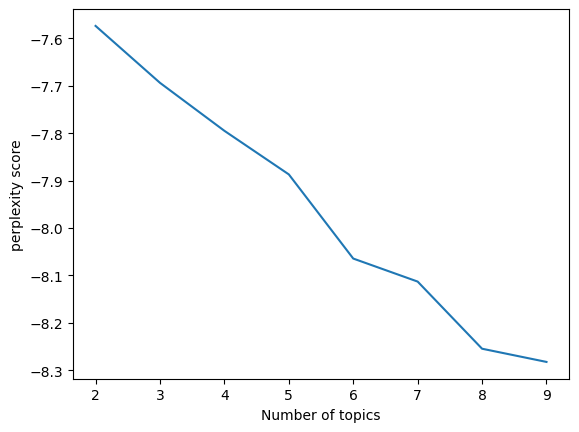

In [54]:
# 축 설정
x = range(2, 10)
plt.plot(x, perplexity_values)
plt.xlabel('Number of topics')
plt.ylabel('perplexity score')

> 2.2.1 Cohearence 그래프 만들기

In [55]:
coherence_values = []
for i in range(2, 10) :
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = i, id2word = dictionary)
    coherence_model = CoherenceModel(model = lda_model, texts = all_documents, dictionary = dictionary, topn = i)
    coherence_score = coherence_model.get_coherence()
    coherence_values.append(coherence_score)
coherence_values

[0.7367513719656595,
 0.6190215263170585,
 0.5843570306450186,
 0.5121610662815053,
 0.4697075031547604,
 0.4801718800574758,
 0.4679459706711188,
 0.40780065768708895]

Text(0, 0.5, 'Coherence score')

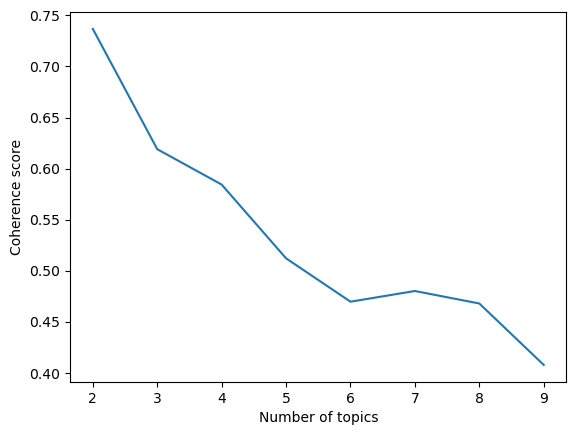

In [56]:
x = range(2, 10)
plt.plot(x, coherence_values)
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')

### 2.3 선정한 토픽 개수로 Action 넘버 매칭

In [67]:
topic_n = 6
lda_model = gensim.models.LdaModel(corpus = corpus, num_topics = topic_n, id2word = dictionary, random_state = 1, passes = 5) 
# random_state : 돌릴 때마다 다른 값이 나오는데 항상 같은 값을 나오게 하는 방법
# passes : epoce 랑 비슷한 기능 -> 너무 크면 과적합 위험 있음

In [68]:
action_align = []
for doc in tqdm(lda_model.get_document_topics(corpus)) :
    label = [] # 클러스터 값
    value = [] # 확률값

    for score in doc :
        label.append(score[0]) # 클러스터값 넣기 위해서
        value.append(score[1]) # 확률값 넣기 위해서

    # 여러개의 (클러스터, 확률) 중 최대의 확률을 찾는 과정
    max_index = np.argmax(value)
    action_n = label[max_index]
    action_align.append(action_n)

action_align

100%|██████████| 71/71 [00:00<00:00, 4655.89it/s]


[1,
 1,
 5,
 1,
 3,
 5,
 0,
 2,
 3,
 5,
 3,
 5,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 4,
 1,
 1,
 5,
 1,
 4,
 1,
 5,
 3,
 1,
 4,
 1,
 1,
 0,
 0,
 3,
 4,
 4,
 4,
 3,
 1,
 0,
 3,
 1,
 4,
 2,
 2,
 1,
 1,
 1,
 5,
 3,
 5,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 3,
 4,
 3,
 1,
 5,
 1,
 4,
 5,
 1,
 1]

In [69]:
df_cluster1['action_cluster'] = action_align
df_cluster1

,time,Review,tagged_review,vector,cluster,action_cluster
2,2023. 5. 3. 9:01,주절주절 홈트를 해요 대 필수 매일 조금씩 세 줌마입니다 대 필수라고 생각하는 근...,"[홈트, 해, 대다, 필수, 매일, 세, 줌마, 대다, 필수, 생각, 근력, 운동,...","[0.6595078, 0.017418364, 1.2061758, 0.65224504...",1,1
10,2021. 11. 10. 14:37,운동 운동 영상 주 회는 운동 하는 중다른 사람들 방해될까봐 그리고 부끄러워서 운...,"[운동, 운동, 영상, 주, 회, 운동, 중, 사람, 방해, 부끄럽다, 운동, 영상...","[0.63065374, -0.3632866, -0.5204896, -0.094380...",1,1
17,2021. 11. 10. 20:11,찐 데일리 겨울에도 즐길 수 있는 실내 스포츠 테린이의 운동 운동그동안 깔짝거리며...,"[찌다, 데, 일리, 겨울, 즐기다, 수, 실내, 스포츠, 테린, 이의, 운동, 운...","[-0.70090955, -1.495075, 0.511196, -0.02174461...",1,5
35,2023. 2. 24. 10:37,리추얼 라이프 나의 건강 관리법 의 질문나만의 규칙적인 습관리추얼 라이프대개 거창...,"[리추얼, 라이프, 건강, 관리, 법, 질문, 규칙, 습, 관리, 추얼, 라이프, ...","[1.0538049, -0.795101, 0.18260065, -0.71494114...",1,1
52,2021. 11. 10. 15:51,운동 코로나를 이기지못하고 사라진룩스필라테스 군자점 오랜만에 포스팅을 올립니다한번 ...,"[운동, 코로나, 이기, 못, 사라지다, 룩스, 필라테스, 군자, 점, 만, 포스팅...","[-1.5950105, 1.7140973, -0.025785215, 3.719138...",1,3
...,...,...,...,...,...,...
708,2021. 11. 10. 14:24,화동사범대 석사 중 당기기 운동 제 운동 영상이요중에서 당기기 운동을 할 기회를...,"[화동, 사범대, 석사, 중, 기기, 운동, 운동, 영상, 이요, 기기, 운동, 기...","[-0.1322695, -0.20870452, 0.207569, 1.3700012,...",1,1
732,2022. 11. 5. 8:00,공지 잠실 댄스학원 중급반 이지댄스 잠실점입니다 의 는 운동 주제군요 저는 요새 춤...,"[공지, 잠실, 댄스, 학원, 중, 반, 댄스, 잠실, 점, 늘다, 운동, 주제, ...","[-0.73634195, 0.7777958, -0.43400747, 1.619193...",1,4
736,2022. 11. 1. 9:21,나는야 취미부자 운동 일지 위치더클라임 클라이밍 짐앤샵 연남점 제 를 보시는 분들이...,"[취미, 부자, 운동, 일지, 위치, 더, 크다, 라임, 크다, 밍, 짐앤, 연남,...","[1.3654749, -0.4165057, -0.14446345, 0.3720104...",1,5
743,2023. 5. 3. 17:00,데일리 홈트 시작 이렇게 하니 좋았어요 개월 내돈내산 홈트를 시작한지도 벌써 개월...,"[데, 일리, 홈트, 시작, 하니, 좋다, 개월, 돈, 산, 홈트, 지도, 벌써, ...","[2.9176116, 2.6359224, -2.123454, 1.3806118, -...",1,1


# ◆ 3. LDA 시각화 (LDAvis)


In [24]:
!pip install pyLDAvis

     ---------------------------------------- 0.0/59.0 kB ? eta -:--:--
     --------------------------- ------------ 41.0/59.0 kB ? eta -:--:--
     ---------------------------------------- 59.0/59.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of pyfume to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.6 MB 4.5 MB/s eta 0:00:01
   ---- ----------------------------------- 0.3/2.6 MB 4.4 MB/s eta 0:00:01
   ----------------- ---------------------- 1.1/2.6 MB 7.8 MB/s eta 0:00:01
   -------------------------------- ------- 2.1/2.6 MB 11.3 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB

In [37]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [73]:
prepared_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(prepared_data, 'ldavis_actor1.html')
pyLDAvis.display(prepared_data)

In [71]:
# 0번 클러스터가 안나와 -> 5개가 무작위로 섞여서 나온거라 수작업으로 조정해줘야해
topics = lda_model.show_topics(num_topics = -1, formatted = True)
topics

[(0,
  '0.020*"운동" + 0.011*"필라테스" + 0.009*"칼리" + 0.009*"스타" + 0.008*"연희동" + 0.007*"헬스장" + 0.007*"연희" + 0.005*"점" + 0.005*"양산시" + 0.004*"캠핑장"'),
 (1,
  '0.042*"운동" + 0.010*"보다" + 0.008*"좋다" + 0.008*"홈트" + 0.007*"자세" + 0.007*"않다" + 0.007*"수" + 0.007*"영상" + 0.007*"없다" + 0.006*"들다"'),
 (2,
  '0.014*"운동" + 0.010*"요가" + 0.007*"노래" + 0.007*"영상" + 0.007*"따르다" + 0.006*"정도" + 0.006*"다이어트" + 0.005*"끄다" + 0.005*"가다" + 0.005*"아니다"'),
 (3,
  '0.049*"운동" + 0.010*"점" + 0.010*"크로스핏" + 0.008*"필라테스" + 0.007*"영상" + 0.006*"보다" + 0.006*"들다" + 0.005*"내" + 0.005*"좋다" + 0.005*"않다"'),
 (4,
  '0.040*"운동" + 0.020*"보다" + 0.013*"따르다" + 0.012*"전신" + 0.011*"모멘트" + 0.011*"핏" + 0.011*"루틴" + 0.011*"랙" + 0.011*"션" + 0.011*"에디"'),
 (5,
  '0.017*"운동" + 0.011*"테니스" + 0.009*"크다" + 0.008*"보다" + 0.007*"진짜" + 0.007*"영상" + 0.006*"수" + 0.006*"분" + 0.006*"않다" + 0.005*"내"')]

In [72]:
new_action_topic = []
for i in df_cluster2.action_cluster :
    if i == 1 : # 처음에 설정한 액션 토픽 값
        new_n = 1 # vis에서 나온 토픽 넘버
    elif i == 2 : 
        new_n = 2
    elif i == 3 :
        new_n = 3
    elif i == 4 :
        new_n = 0
    else :
        new_n = 4

    new_action_topic.append(new_n)

In [32]:
df_cluster2.action_cluster = new_action_topic
df_cluster2

NameError: name 'new_action_topic' is not defined

pyLDAvis의 토픽 번호와 매핑된 모델 토픽 번호 출력 자동화 코드

In [ ]:

import pandas as pd
import pickle
from tqdm import tqdm
import warnings
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np
import pyLDAvis.gensim as gensimvis
import pyLDAvis
 
warnings.filterwarnings('ignore')
 
def load_data(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)
 
def prepare_documents(df, cluster_label):
    cluster_data = df[df['cluster'] == cluster_label]
    return cluster_data['tagged_review'].tolist()
 
def create_dictionary(documents):
    return Dictionary(documents)
 
def create_corpus(documents, dictionary):
    return [dictionary.doc2bow(text) for text in documents]
 
def calculate_scores(corpus, dictionary, documents, start=2, end=10):
    perplexity_values = []
    coherence_values = []
   
    for i in tqdm(range(start, end), desc="Calculating Perplexity and Coherence Scores"):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=i, random_state=42)
        perplexity_values.append(model.log_perplexity(corpus))
        coherence_model = CoherenceModel(model=model, texts=documents, dictionary=dictionary, topn=i)
        coherence_values.append(coherence_model.get_coherence())
       
    return perplexity_values, coherence_values
 
def plot_scores(perplexity_values, coherence_values, start=2, end=10):
    x = range(start, end)
    plt.figure(figsize=(12, 6))
 
    plt.subplot(1, 2, 1)
    plt.plot(x, perplexity_values, marker='o')
    plt.xlabel('Number of topics')
    plt.ylabel('Perplexity score')
    plt.title('Perplexity Scores')
 
    plt.subplot(1, 2, 2)
    plt.plot(x, coherence_values, marker='o')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence score')
    plt.title('Coherence Scores')
 
    plt.tight_layout()
    plt.show()
 
def extract_topic_keywords(vis_data, num_topics):
    return [
        vis_data.topic_info[vis_data.topic_info.Category == f'Topic{i+1}']
        .sort_values('Freq', ascending=False)
        .Term.values[:10]
        for i in range(num_topics)
    ]
 
def map_topics(vis_keywords, model_keywords, num_topics):
    topic_mapping = {}
   
    for vis_idx, vis_kw in enumerate(vis_keywords):
        for model_idx, model_kw in enumerate(model_keywords):
            if set(vis_kw) == set(model_kw):
                topic_mapping[vis_idx + 1] = model_idx
                break
               
    return topic_mapping
 
def assign_topics_to_documents(ldamodel, corpus):
    action_align = []
 
    for doc in tqdm(ldamodel.get_document_topics(corpus), desc="Assigning Topics to Documents"):
        labels, values = zip(*doc)
        action_align.append(labels[np.argmax(values)])
 
    return action_align
 
# 데이터 로드
df = load_data('클러스터링 결과.pkl')
 
# 클러스터 0의 데이터 준비
documents = prepare_documents(df, cluster_label=0)
 
# 사전 및 코퍼스 생성
dictionary = create_dictionary(documents)
corpus = create_corpus(documents, dictionary)
 
# 퍼플렉서티 및 코히런스 점수 계산
perplexity_values, coherence_values = calculate_scores(corpus, dictionary, documents)
 
# 퍼플렉서티 및 코히런스 점수 그래프
plot_scores(perplexity_values, coherence_values)
 
# 최적 토픽 수로 LDA 모델 학습
optimal_topic_num = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_topic_num, random_state=42)
 
# pyLDAvis 시각화 준비
prepared_data = gensimvis.prepare(ldamodel, corpus, dictionary)
 
# pyLDAvis와 ldamodel의 토픽 키워드 추출 및 매핑
vis_topic_keywords = extract_topic_keywords(prepared_data, optimal_topic_num)
model_topic_keywords = [[word for word, prob in ldamodel.show_topic(i, topn=10)] for i in range(optimal_topic_num)]
topic_mapping = map_topics(vis_topic_keywords, model_topic_keywords, optimal_topic_num)
 
# 토픽 확인
topics = ldamodel.show_topics(num_topics=optimal_topic_num, formatted=True)
for idx, topic in topics:
    print(f"Model Topic {idx}: {topic}")
 
# pyLDAvis의 토픽 번호와 매핑된 모델 토픽 번호 출력
print("\nTopic Mapping (pyLDAvis -> Model):")
for vis_idx, model_idx in topic_mapping.items():
    print(f"pyLDAvis Topic {vis_idx} -> Model Topic {model_idx}")
 
# 문서별 최적 토픽 할당
action_align = assign_topics_to_documents(ldamodel, corpus)
 
# 각 문서의 할당된 토픽 출력
print(action_align)
 
# pyLDAvis 시각화 파일 저장
pyLDAvis.save_html(prepared_data, 'pyLDAvis_output.html')
 
# pyLDAvis 시각화
pyLDAvis.display(prepared_data)
 

# ◆ 4. LDA 분석을 위한 후작업
* LDAvis와 LDA모델의 토픽 넘버 매칭
* LDAvis 결과와 LDA모델의 결과를 보고 직접 매칭해야한다.